CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_7")

In [3]:
from utils import plot_samples, plot_accuracy_metrics
from models import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.Resize((28, 28)),
    # transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.MNIST('../data', train=True, download=True)
# test_data = datasets.MNIST('../data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 332079675.75it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21697240.52it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 157229377.45it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5017258.04it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

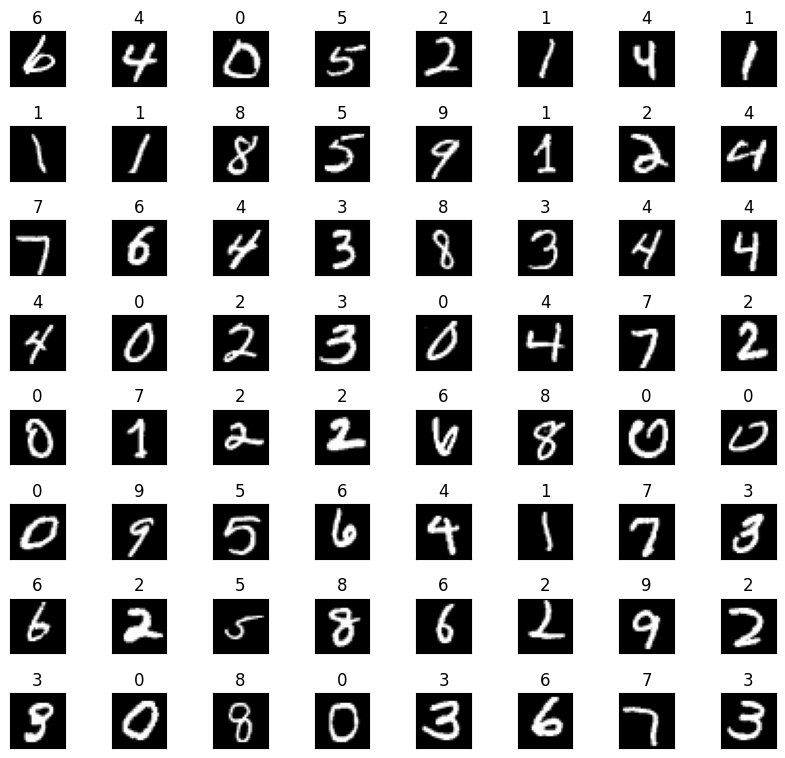

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples(batch_data,batch_label)

In [10]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 10]          40,970
Total params: 428,810
Trainable params: 428,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.64
Estimated Total Size (MB): 2.31
----------------------------------------------------------------


CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=0.2050 Batch_id=117 Accuracy=75.25: 100%|██████████| 118/118 [00:16<00:00,  7.37it/s]


Test set: Average loss: 0.1668, Accuracy: 9501/10000 (95.01%)

Epoch 2


Train: Loss=0.1296 Batch_id=117 Accuracy=96.01: 100%|██████████| 118/118 [00:15<00:00,  7.50it/s]


Test set: Average loss: 0.1046, Accuracy: 9687/10000 (96.87%)

Epoch 3


Train: Loss=0.0872 Batch_id=117 Accuracy=97.30: 100%|██████████| 118/118 [00:15<00:00,  7.65it/s]


Test set: Average loss: 0.0674, Accuracy: 9784/10000 (97.84%)

Epoch 4


Train: Loss=0.0131 Batch_id=117 Accuracy=97.83: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0522, Accuracy: 9830/10000 (98.30%)

Epoch 5


Train: Loss=0.0201 Batch_id=117 Accuracy=98.26: 100%|██████████| 118/118 [00:17<00:00,  6.72it/s]


Test set: Average loss: 0.0445, Accuracy: 9860/10000 (98.60%)

Epoch 6


Train: Loss=0.0287 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:16<00:00,  7.33it/s]


Test set: Average loss: 0.0438, Accuracy: 9863/10000 (98.63%)

Epoch 7


Train: Loss=0.0495 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:15<00:00,  7.44it/s]


Test set: Average loss: 0.0396, Accuracy: 9859/10000 (98.59%)

Epoch 8


Train: Loss=0.1009 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:15<00:00,  7.59it/s]


Test set: Average loss: 0.0382, Accuracy: 9877/10000 (98.77%)

Epoch 9


Train: Loss=0.0366 Batch_id=117 Accuracy=98.93: 100%|██████████| 118/118 [00:16<00:00,  7.30it/s]


Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

Epoch 10


Train: Loss=0.0133 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:16<00:00,  7.31it/s]


Test set: Average loss: 0.0352, Accuracy: 9875/10000 (98.75%)

Epoch 11


Train: Loss=0.0028 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:15<00:00,  7.43it/s]


Test set: Average loss: 0.0321, Accuracy: 9890/10000 (98.90%)

Epoch 12


Train: Loss=0.0678 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:16<00:00,  7.36it/s]


Test set: Average loss: 0.0304, Accuracy: 9895/10000 (98.95%)

Epoch 13


Train: Loss=0.0070 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:16<00:00,  7.17it/s]


Test set: Average loss: 0.0317, Accuracy: 9896/10000 (98.96%)

Epoch 14


Train: Loss=0.0039 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:15<00:00,  7.48it/s]


Test set: Average loss: 0.0348, Accuracy: 9887/10000 (98.87%)

Epoch 15


Train: Loss=0.0097 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:15<00:00,  7.43it/s]


Test set: Average loss: 0.0294, Accuracy: 9899/10000 (98.99%)



CODE BLOCK: 11

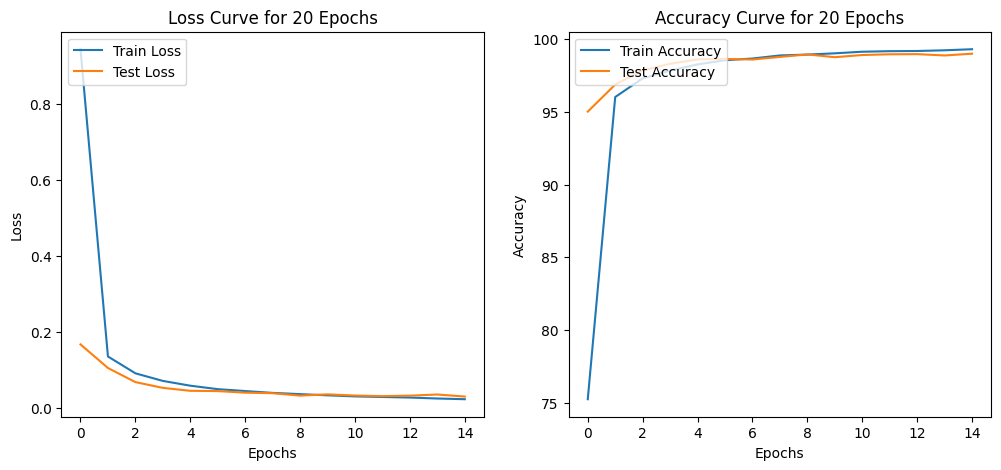

In [16]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc)